# code and date 
http://localhost:8206/lab/workspaces/auto-n/tree/code/MNF/notebooks/STRING_Data_11.5/test_withLowDCA_phylumeffect_STRINGFullPhyBalancePhyla_visulization_fullHomologous_oneBestHomologousPP.ipynb


# load lib and set data 

In [32]:
import sys
import os 
import pandas as pd
import numpy as np 
import copy 
import random
from collections import defaultdict
import pickle
import glob

import multiprocessing as mp 
import subprocess

import matplotlib.pyplot as plt 
import seaborn as sns

from Bio import AlignIO
from Bio import SeqIO
from Bio.Blast import NCBIXML


from Bio.PDB import PDBParser

import networkx as nx
from pyvis.network import Network #https://pyvis.readthedocs.io/en/latest/
from sklearn.manifold import MDS



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
from sklearn.utils import shuffle

import  sklearn.metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


from scipy.stats import ttest_ind


import pkg_resources



In [33]:
%reload_ext autoreload
%autoreload 2

sys.path.append('../src/utilities/')

from ROC_curve import DCA_RocCurve
from ROC_curve import Random_RocCurve

from Check_SameCogPair_problem import sepCogPairs_topDCAs_ML_predictions




from IntergrateBestHomologousPPCoEvo_unNameSorted_ML import sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions

from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_SubjectInfo_top5DCAs_FullBestHomologousPP
from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_BestHomologousDCAs_top5DCAs_fromMultiSpes
from IntergrateBestHomologousPPCoEvo_top5_unNameSorted_ML import VariousReplacing_sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_top5DCAs_uniquePhyla_ML_predictions


from biasCheck import getAllIdxOf_fixed_negVSpos_ratio_keepCombination_from_OriginalFrame
from ML_training import sepCogPairs_ML_predictions_allTypeFeas
from collect_topCoEvos import get_topRanking_CoEvo_file



In [34]:
n_jobs=50#80    #50  # 30

scoring_metrics=sklearn.metrics.make_scorer(sklearn.metrics.f1_score)    # None, sklearn.metrics.make_scorer(sklearn.metrics.f1_score)

In [35]:
Query_tuple=('1224', '511145')
Subject_tupleList=[("1239","1274374"),('201174', '105422'), ('976', '411476'),] 

In [36]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/"

In [37]:
CoEvo_data_folder=notebookData_folder+"PPI_Coevolution/CoEvo_data_STRING"+"11.5"+"/"
Query_input_root_folder=CoEvo_data_folder+"allPPI_"+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_eggNOGfilteredData/"
Query_Benchmark_folder=Query_input_root_folder+"STRINGFullPhyBalancePhyla_Benchmark/"
Query_ML_inputPath=Query_Benchmark_folder+"ML_inputs/"

Query_DCA_coevolutoin_path=Query_input_root_folder+"coevolutoin_result_DCA/"


Query_ML_inputPath

'/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/ML_inputs/'

In [38]:
Query_DCA_coevolutoin_path,Query_Benchmark_folder

('/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/',
 '/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/')

In [39]:

EggNOG_groupPath=notebookData_folder+"STRING_Data_11.5/eggnog5AddSTRING11.5_Species/groups/"


In [40]:
%%time
# read cog information 
max_level="2" #"2", "1224"
EggNOG_group_level2=pd.read_csv(EggNOG_groupPath+max_level+".tsv",
                                header=None,index_col=None,sep="\t")




CPU times: user 20.6 s, sys: 3.22 s, total: 23.8 s
Wall time: 23.8 s


In [ ]:
Query_input_root_folder

# prepare best homologous protein pp 

In [42]:
%%time 
with open(notebookData_folder+"PPI_Coevolution/STRING_data_11.5/511145_EggNOGmaxLevel1224_allQuery2SubjectPPIMapping/NameUnsorted_Query2Subject_QueSpeAllPPI_homologous_dict_listDict.pickle", 'rb') as handle:
        Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict=pickle.load(handle)
        


CPU times: user 1.71 s, sys: 112 ms, total: 1.82 s
Wall time: 1.82 s


In [43]:
for _,t_dict in Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.items():
    print(_)
    print(len(t_dict))
    count=0
    for v in t_dict.values():
        count += len(v)
    print(count,count/2)

('1239', '1274374')
1510551
3021102 1510551.0
('201174', '105422')
1598711
3197422 1598711.0
('976', '411476')
1229632
2459264 1229632.0
('2', '179408')
1269201
2538402 1269201.0


In [44]:
Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict={k:v for k,v in Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.items() if k in Subject_tupleList }

Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [45]:
list(Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict[('1239', '1274374')].items())[0]



(('511145.b0003', '511145.b0004'),
 ('1274374.CBLK010000071_gene1043', '1274374.CBLK010000070_gene1131'))

# STRING 11.5, phylum 1224, species 511145

In [46]:
%%time
STRING115EggNog1224Spe511145_topDCAs_predicted_results=sepCogPairs_topDCAs_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                                                                                          EggNOG_group_level2=EggNOG_group_level2,
                                                                           ML_methods=["LR","RF"], #["LR","RF"],
                                                                           DCA_thres=0,DCA_number=50,selDca_number=20,
                                                                CoEvo_data_folder=CoEvo_data_folder,
                                                                                                       prefix="allPPI_",
                                                                            benchmark_suffix="STRINGFullPhyBalancePhyla_Benchmark/",
                                                                                          ifReCollect=False,
                                                                                         saveFrame=True,
                                                                                         overwrite=False,
                                                                                        splitPosandNeg=False,
                                                                                         sort_frame=False,
                                                                                          use_multiprocessing=30,
                                                                                    n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                         )


# second time with  ML_methods=["LR","RF"
# CPU times: user 22min 16s, sys: 37.6 s, total: 22min 53s
# Wall time: 1h 26min 41

# # for F1 scoring 
# CPU times: user 17min 56s, sys: 36.2 s, total: 18min 32s
# Wall time: 2h 15min 31s


ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/
allPPI_allInfo_frame.shape: (420412, 5)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 420412
len(allPPI_info): 420412
top_CoEvo_frame.shape: (420412, 152)
sys.getsizeof(top_CoEvo_frame)/(1024*1024*1024):0.5238795801997185
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (336329, 20) (84083, 20) (336329,) (84083,)
[['COG1516', 'COG0479'], ['COG2011', 'COG0250'], ['COG0024', 'COG3123']]
len(cogs_train_dict): 249966
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 84083 34380 49703
XtopDCAs_train.shape,ytopDCAs_train.shape,sum(ytopDCAs_train

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_notebook/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_gpu/lib/python3.7/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_notebook/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_gpu/lib/python3.7/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (mos

LR ConvergenceWarning:  Liblinear failed to converge, increase the number of iterations.


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_notebook/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_gpu/lib/python3.7/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_notebook/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/mnt/mnemo5/tao/anaconda3/envs/py37_gpu/lib/python3.7/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (mos

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1)}

In [47]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]["Model"]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fa530bb2150>,
             estimator=RandomForestClassifier(n_jobs=4, random_state=0),
             n_jobs=50,
             param_grid={'class_weight': [{1: 1}, {1: 10}, {1: 50}],
                         'max_depth': [5, 8, 8], 'max_features': [2, 3, 5],
                         'n_estimators': [10, 100, 500]},
             scoring=make_scorer(f1_score))

In [48]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]["Model"].best_estimator_


RandomForestClassifier(class_weight={1: 10}, max_depth=5, max_features=5,
                       n_estimators=500, n_jobs=4, random_state=0)

In [49]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results.keys()

dict_keys(['XtopDCAs', 'YtopDCAs', 'XtopDCAs_train', 'XtopDCAs_test', 'ytopDCAs_train', 'ytopDCAs_test', 'LR', 'RF', 'updated_allPPI_allInfo_frame'])

In [50]:
sum(STRING115EggNog1224Spe511145_topDCAs_predicted_results["YtopDCAs"]==1),sum(STRING115EggNog1224Spe511145_topDCAs_predicted_results["YtopDCAs"]==0)

(5532, 414880)

### use plot check overfitting 

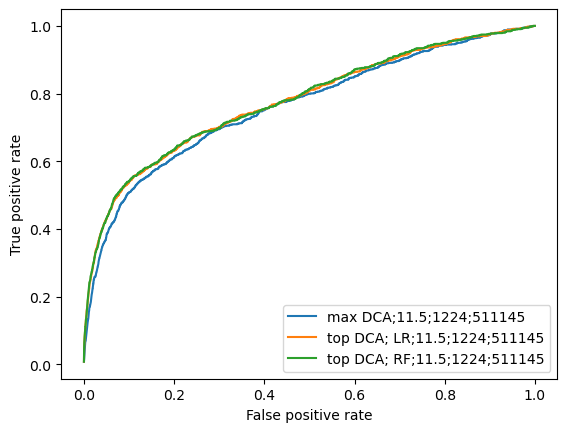

In [51]:

count_label="rate"
step=10
DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="max DCA"+";11.5;1224;511145",step=step)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step)

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="top DCA; RF"+";11.5;1224;511145",step=step)



plt.show()

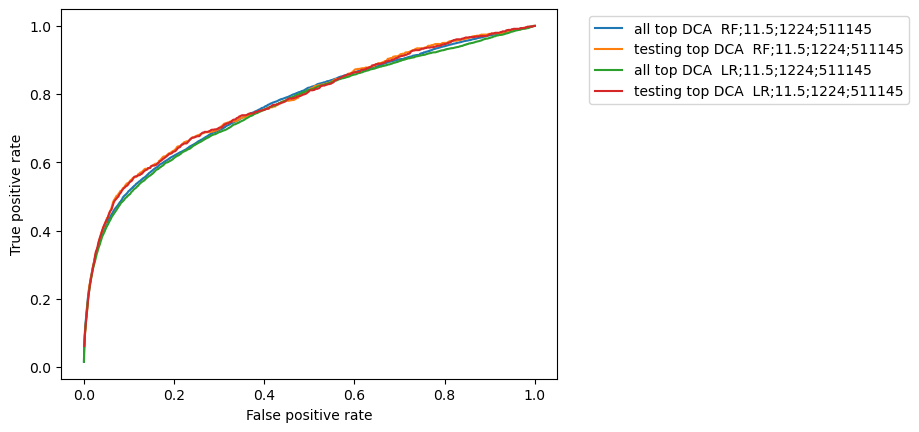

CPU times: user 4.67 s, sys: 124 ms, total: 4.8 s
Wall time: 4.62 s


In [52]:
%%time
count_label="rate"
step=100
zoom_thres=None



DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["updated_allPPI_allInfo_frame"]["RF_onesProb"], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results['YtopDCAs'],
             count_label=count_label,legend="all top DCA  RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="testing top DCA  RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["updated_allPPI_allInfo_frame"]["LR_onesProb"], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results['YtopDCAs'],
             count_label=count_label,legend="all top DCA  LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="testing top DCA  LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

# For Ecoli 11.5, get its top 5 DCA score from its BestHomologous pp from other speceis 



In [53]:

HighDCA_Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                 header=0,index_col=None,sep="\t")
print(HighDCA_Query_allPPI_allInfo_frame.shape)
HighDCA_Query_allPPI_allInfo_frame.head(n=3)

(420412, 5)


,STRING_ID1,STRING_ID2,benchmark_status,len1,len2
0,511145.b0089,511145.b0094,P,390,410
1,511145.b2277,511145.b2278,P,491,608
2,511145.b2751,511145.b2762,P,471,238


In [54]:
%%time 

HighDCA_Query_allPPI_info=HighDCA_Query_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","benchmark_status","len1","len2"]].values.tolist()

HighDCA_Query_allPPI_allInfo_dict=dict([((p1,p2),(s,len1,len2)) for p1,p2,s,len1,len2 in HighDCA_Query_allPPI_info])




CPU times: user 324 ms, sys: 48 ms, total: 372 ms
Wall time: 371 ms


In [55]:
HighDCA_Query_topRanking_pydcaFNAPC_file=Query_Benchmark_folder+"DCA_thres_"+str(0)+"_topRanking_pydcaFNAPC_frame.csv" 
print(HighDCA_Query_topRanking_pydcaFNAPC_file)

HighDCA_Query_allPPI_info=HighDCA_Query_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()



/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/DCA_thres_0_topRanking_pydcaFNAPC_frame.csv


In [56]:
%%time 
HighDCA_Query_top_pydcaFNAPC_dict=get_topRanking_CoEvo_file(topRanking_CoEvo_file=HighDCA_Query_topRanking_pydcaFNAPC_file,
                                               coevolutoin_path=Query_DCA_coevolutoin_path,
                                               coevo_suffix="_pydcaFNAPC_array",
                                               allPPI_info=HighDCA_Query_allPPI_info, 
                                               returnDic=True,
                                               overwrite=False,
                                            use_multiprocessing=10
                                                             )


top_CoEvo_frame.shape: (420412, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.0031323805451393127
CPU times: user 10.6 s, sys: 1.64 s, total: 12.2 s
Wall time: 12.2 s


In [57]:
# here to read all homoglogs dca info we here 
# and because when we computer homologous DCA , we also use pp with low dca in ecoli speceis, so it has all 
BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict=get_SubjectInfo_top5DCAs_FullBestHomologousPP(Query_tuple,
                                                                                                  Subject_tupleList,
                                                                                                  STRING_version="11.5",
                                                                                                  benchmark_suffix="AllPPI_Benchmark/",
                                                                                                CoEvo_data_folder=CoEvo_data_folder,
                                                                                                  topDCA_num=5,
                                                                                                   returnDic=True,
                                                                                                    overwrite=False,
                                                                                                    use_multiprocessing=10,
                                                                                                        )



1239 1274374
BestHomologousPP_Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
allPPI_allInfo_frame.shape: (513280, 4)
BestHomologousPP_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/coevolutoin_result_DCA/
topRanking_pydcaFNAPC_file:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
top_CoEvo_frame.shape: (513280, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.003824301064014435
len(t

In [58]:

BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [59]:
list(BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict[('1239', '1274374')].items())[0]

(('1274374.CBLK010000064_gene892', '1274374.CBLK010000065_gene1568'),
 [1.0909, 0.7794, 0.7737, 0.7638, 0.6774])

In [63]:
Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [64]:
%%time
Query_top_pydcaFNAPC_top5DCAs_dict={pp:[v[3*i] for i in range(5)] for pp, v in HighDCA_Query_top_pydcaFNAPC_dict.items()}

HighDCA_Query_BestHomologousDCAs_top5DCAs_dict=get_BestHomologousDCAs_top5DCAs_fromMultiSpes(Query_allPPI_allInfo_dict=HighDCA_Query_allPPI_allInfo_dict,
                                    Query_allPPI_top5DCAs_dict=Query_top_pydcaFNAPC_top5DCAs_dict,
                                    BestHomologousPP_Subject_allPPI_top5DCAs_listDict=BestHomologousPP_top5DCAs_Subject_allPPI_allInfo_dict_listDict,
                                    Query2Subject_BestHomologous_ignoreSubjectDCA_dict_listDict=Query2Subject_QuerySpeAllPPI_BestHomologous_ignoreSubjectDCA_dict_listDict,
                                    topDCA_num=5,
                                    with_status=True,    )

CPU times: user 3.74 s, sys: 124 ms, total: 3.86 s
Wall time: 3.86 s


In [65]:
print(list(HighDCA_Query_BestHomologousDCAs_top5DCAs_dict.items())[0])

(('511145.b0089', '511145.b0094'), ['P', 1.024, 0.8673, 0.857, 0.8486, 0.7513, 0.7327, 0.7187, 0.7027, 0.687, 0.6318, nan, nan, nan, nan, nan, 1.1556, 0.9832, 0.8901, 0.8292, 0.8274])


In [66]:
print(len(HighDCA_Query_allPPI_allInfo_dict),len(HighDCA_Query_BestHomologousDCAs_top5DCAs_dict))

420412 420412


# train LR for integrated  top 5 DCA scores  with only unique phylum


In [67]:
%%time
# remember here is tree depth =10 remove over fitting , not 8
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results=sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                  Query_BestHomologousDCAs_dict=HighDCA_Query_BestHomologousDCAs_top5DCAs_dict,
                  ML_methods=["LR","RF"] ,#["LR","RF"],
                   EggNOG_group_level2=EggNOG_group_level2,
                  CoEvo_type="DCA",
                  deleting_column=None,
                  DCA_thres=0,
                    fillMissingValue=-1,
                    topDCA_num=5,
                    given_benchmark_folder=Query_Benchmark_folder,
                    splitPosandNeg=False,
                    sort_frame=False,
                    CoEvo_data_folder=CoEvo_data_folder,
                    prefix="allPPI_",
                    benchmark_suffix="STRINGFullPhyBalancePhyla_Benchmark/",
                    n_jobs=n_jobs,
                    scoring_metrics=scoring_metrics,
                    BestHomologousDCAs_dict_withStatus=True,)

# CPU times: user 16min 26s, sys: 32.9 s, total: 16min 59s
# Wall time: 1h 12min 56s

# for F1 scoring 

input_root_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/
 ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/
allPPI_allInfo_frame.shape: (420412, 5)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 420412
OnlyTopPosNeg_NonPara_XBestHomologousDCAs.shape: (420412, 20)
after deleting colum, OnlyTopPosNeg_NonPara_XBestHomologousDCA

In [68]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results.keys()

dict_keys(['XBestHomologousDCAs', 'YBestHomologousDCAs', 'XBestHomologousDCAs_train', 'XBestHomologousDCAs_test', 'yBestHomologousDCAs_train', 'yBestHomologousDCAs_test', 'LR', 'RF', 'updated_allPPI_allInfo_frame'])

In [69]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["updated_allPPI_allInfo_frame"].head()

,STRING_ID1,STRING_ID2,benchmark_status,len1,len2,LR_onesProb,RF_onesProb
0,511145.b0089,511145.b0094,P,390,410,0.129000,0.056195
1,511145.b2277,511145.b2278,P,491,608,0.136363,0.079554
2,511145.b2751,511145.b2762,P,471,238,0.042721,0.055341
3,511145.b1716,511145.b3296,P,117,206,0.639532,0.948657
4,511145.b0864,511145.b3270,P,238,365,0.079340,0.054654


In [70]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]["Model"]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fa6076301d0>,
             estimator=RandomForestClassifier(n_jobs=4, random_state=0),
             n_jobs=50,
             param_grid={'class_weight': [{1: 1}, {1: 10}, {1: 50}],
                         'max_depth': [5, 8, 8], 'max_features': [2, 3, 5],
                         'n_estimators': [10, 100, 500]},
             scoring=make_scorer(f1_score))

In [71]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs']

array([[ 1.024 ,  0.8673,  0.857 , ...,  0.8901,  0.8292,  0.8274],
       [ 1.5669,  1.192 ,  1.1779, ..., -1.    , -1.    , -1.    ],
       [ 0.8772,  0.7885,  0.7234, ..., -1.    , -1.    , -1.    ],
       ...,
       [ 0.5842,  0.5558,  0.5509, ..., -1.    , -1.    , -1.    ],
       [ 0.6309,  0.6301,  0.6225, ..., -1.    , -1.    , -1.    ],
       [ 1.6636,  1.4729,  1.4376, ..., -1.    , -1.    , -1.    ]])

In [72]:
all(STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"]==STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"])





True

In [73]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"].shape

(49703,)

In [74]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"].shape

(49703,)

In [75]:
%%time 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,\
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_testPPs=sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                  Query_BestHomologousDCAs_dict=HighDCA_Query_BestHomologousDCAs_top5DCAs_dict,
                  ML_methods=["LR","RF"] ,#["LR","RF"],
                   EggNOG_group_level2=EggNOG_group_level2,
                  CoEvo_type="DCA",
                  deleting_column=None,
                  DCA_thres=0,
                    fillMissingValue=-1,
                    topDCA_num=5,
                    given_benchmark_folder=Query_Benchmark_folder,
                    splitPosandNeg=False,
                    sort_frame=False,
                    CoEvo_data_folder=CoEvo_data_folder,
                    prefix="allPPI_",
                    benchmark_suffix="STRINGFullPhyBalancePhyla_Benchmark/",
                    n_jobs=n_jobs,
                    scoring_metrics=scoring_metrics,
                    BestHomologousDCAs_dict_withStatus=True,
                    getTrainandTestPPTuples=True)



print(len(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs))
print(len(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_testPPs))


count=0
for pp in STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs:
    if HighDCA_Query_allPPI_allInfo_dict[pp][0]=="P":
        count +=1
print(count)

input_root_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/
 ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/
allPPI_allInfo_frame.shape: (420412, 5)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 420412
getTrainandTestPPTuples only:
all_PPTuples[0] ('511145.b0089', '511145.b0094')
type(cogs_train),type(cogs_test): <class 'lis

### use plot check overfitting 

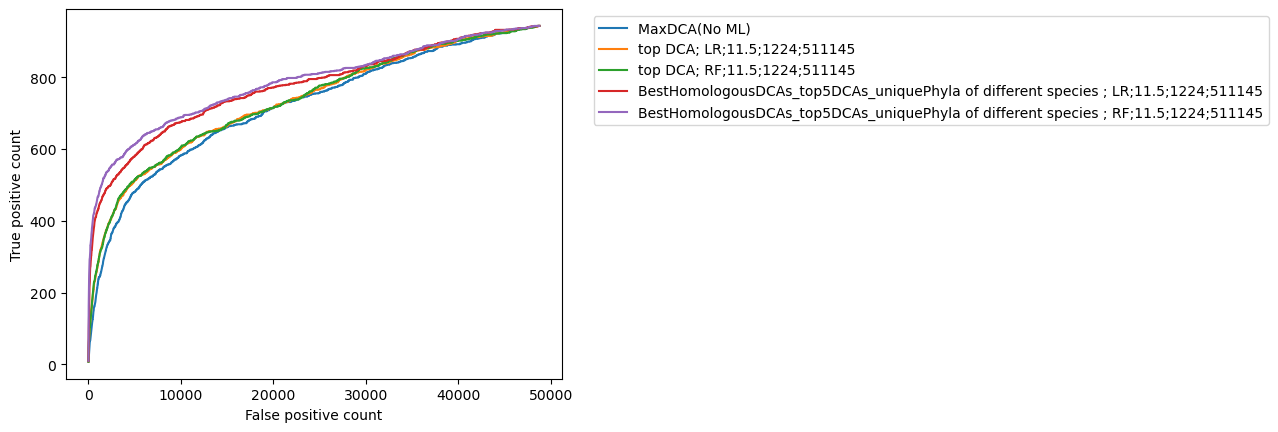

In [76]:

count_label="count"
step=10
zoom_thres=None

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="MaxDCA(No ML)",
             step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,legend="top DCA; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

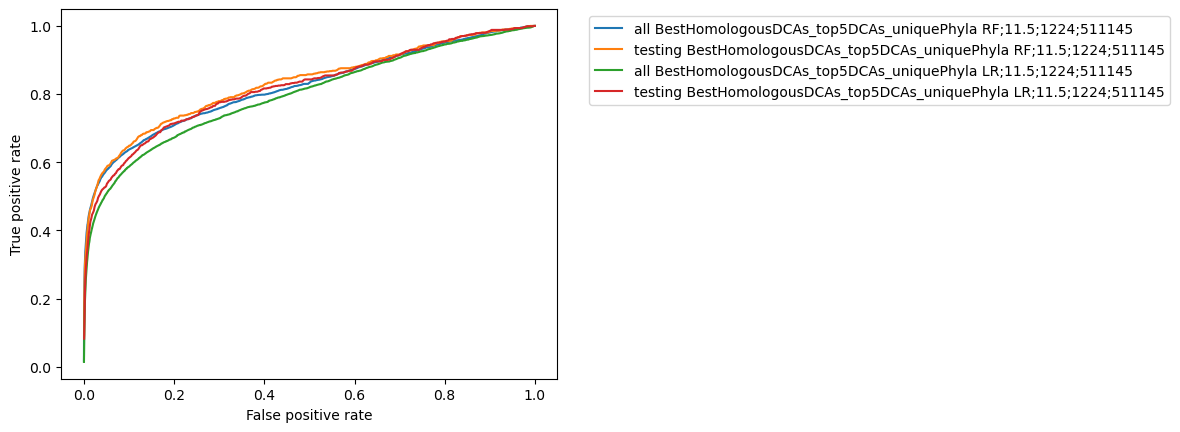

CPU times: user 4.8 s, sys: 152 ms, total: 4.95 s
Wall time: 4.76 s


In [77]:
%%time
count_label="rate"
step=100
zoom_thres=None



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["updated_allPPI_allInfo_frame"]["RF_onesProb"], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'],
             count_label=count_label,legend="all BestHomologousDCAs_top5DCAs_uniquePhyla RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,legend="testing BestHomologousDCAs_top5DCAs_uniquePhyla RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["updated_allPPI_allInfo_frame"]["LR_onesProb"], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'],
             count_label=count_label,legend="all BestHomologousDCAs_top5DCAs_uniquePhyla LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,legend="testing BestHomologousDCAs_top5DCAs_uniquePhyla LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

In [78]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]["Model"].best_estimator_

RandomForestClassifier(class_weight={1: 10}, max_depth=8, max_features=5,
                       n_estimators=500, n_jobs=4, random_state=0)

### save ML model to identify novel ppi in whole proteome level 

In [79]:
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_LR.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['Model'].best_estimator_,f)
    
    
    
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_RF.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['Model'].best_estimator_,f)
    
    
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,f)
    
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['updated_allPPI_allInfo_frame'].to_csv(\
os.path.join(Query_Benchmark_folder,
    f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_allPPI_allInfo_frame.csv"),
header=True,index=None)



In [80]:
Query_Benchmark_folder

'/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/'

### check replacing 

In [81]:
%%time

replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results=VariousReplacing_sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_top5DCAs_uniquePhyla_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                  Query_BestHomologousDCAs_dict=HighDCA_Query_BestHomologousDCAs_top5DCAs_dict,
                  ML_methods=["LR","RF"],#["LR","RF"],
                   EggNOG_group_level2=EggNOG_group_level2,
                  CoEvo_type="DCA",
                  topDCA_num=5,
                  deleting_column=None,
                  DCA_thres=0,
                  fillDCAValue=1,
                    fillMissingValue=-1,
                    replacing=True,
                    replacing_strageties="replacingDCAScores",
                    given_benchmark_folder=Query_Benchmark_folder,
                    splitPosandNeg=False,
                    sort_frame=False,
                    CoEvo_data_folder=CoEvo_data_folder,
                    prefix="allPPI_",
                    benchmark_suffix="STRINGFullPhyBalancePhyla_Benchmark/",
                    n_jobs=n_jobs,
                    scoring_metrics=scoring_metrics,
                    BestHomologousDCAs_dict_withStatus=True,)

# CPU times: user 26.8 s, sys: 27.8 s, total: 54.6 s
# Wall time: 9min 41s

Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/
allPPI_allInfo_frame.shape: (420412, 5)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 420412
OnlyTopPosNeg_NonPara_XBestHomologousDCAs.shape: (420412, 20)
after deleting colum, OnlyTopPosNeg_NonPara_XBestHomologousDCAs.shape: (420412, 20)
The replacing_strageties is  replacingDCAScores
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (336329, 20) (84083, 20) (336329,) (84083,)
[['COG1516', 'COG0479'], ['COG2011', 'COG0250'], ['COG0024', 'COG3123']]
len(cogs_train_dict): 249966
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 84083 34380 49703
XBestHomologousDCAs_train.shape,yBestHomologousDCAs_train.shape,sum(yBestHomologousDCAs_train),yBestHomologousDCAs_test.shape,sum(yBestHomologousDCAs_test): (370709, 20) (37

In [82]:
replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results.keys()

dict_keys(['XBestHomologousDCAs', 'YBestHomologousDCAs', 'XBestHomologousDCAs_train', 'XBestHomologousDCAs_test', 'yBestHomologousDCAs_train', 'yBestHomologousDCAs_test', 'LR', 'RF', 'updated_allPPI_allInfo_frame'])

In [83]:
replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs_train'].shape

(370709, 20)

In [84]:
replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs_train']

array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [85]:
replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs_train'][0:3,:]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.]])

In [86]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs_train']

array([[ 1.22  ,  0.9964,  0.8993, ..., -1.    , -1.    , -1.    ],
       [ 1.2389,  1.0651,  1.0116, ..., -1.    , -1.    , -1.    ],
       [ 1.058 ,  1.0575,  1.0542, ..., -1.    , -1.    , -1.    ],
       ...,
       [ 0.7907,  0.7145,  0.7105, ..., -1.    , -1.    , -1.    ],
       [ 0.7464,  0.7458,  0.7091, ..., -1.    , -1.    , -1.    ],
       [ 1.2947,  1.0969,  0.9446, ..., -1.    , -1.    , -1.    ]])

In [87]:
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs_train'][0:3,:]

array([[ 1.22  ,  0.9964,  0.8993,  0.8286,  0.7849,  1.3779,  1.17  ,
         1.1622,  1.1337,  1.1156, -1.    , -1.    , -1.    , -1.    ,
        -1.    , -1.    , -1.    , -1.    , -1.    , -1.    ],
       [ 1.2389,  1.0651,  1.0116,  1.0045,  0.9756,  1.2361,  1.1739,
         1.163 ,  1.161 ,  1.1426, -1.    , -1.    , -1.    , -1.    ,
        -1.    , -1.    , -1.    , -1.    , -1.    , -1.    ],
       [ 1.058 ,  1.0575,  1.0542,  0.9503,  0.9496, -1.    , -1.    ,
        -1.    , -1.    , -1.    , -1.    , -1.    , -1.    , -1.    ,
        -1.    , -1.    , -1.    , -1.    , -1.    , -1.    ]])

In [88]:
set(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['updated_allPPI_allInfo_frame']["LR_onesProb"])

{0.22519781168019903,
 0.2926621752935018,
 0.38434682361223227,
 0.43586065133756435,
 0.470534358371302,
 0.5237721754397928,
 0.6239883146927632,
 0.7025876444988198}

# revise ratio at each -1 group , and consider order and combination of -1



YBestHomologousDCAs_replace.shape: (420412,)
beforeFixRatio_test_Phaly_posPPInum, beforeFixRatio_test_Phaly_negPPInum,beforeFixRatio_test_Phaly_negVSpos_ratio: defaultdict(<class 'int'>, {0.25: 1131, 0.5: 1507, 0.0: 1681, 0.75: 1213}) defaultdict(<class 'int'>, {0.5: 115711, 0.75: 200401, 0.0: 24958, 0.25: 73810}) {0.5: 76.7823490378235, 0.75: 165.21104699093158, 0.0: 14.84711481261154, 0.25: 65.26083112290009}
0.0
0.25
0.5
0.75
1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_-1.0_-1.0_-1.0_-1.0_-1.0_1.0_1.0_1.0_1.0_1.0 215 13969 64.97209302325581
1.0_1.0_1.0_1.0_1.0_-1.0_-1.0_-1.0_-1.0_-1.0_1.0_1.0_1.0_1.0_1.0_-1.0_-1.0_-1.0_-1.0_-1.0 512 57944 113.171875
1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0 1681 24958 14.84711481261154
1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_1.0_-1.0_-1.0_-1.0_-1.0_-1.0 737 52831 71.68385345997287
1.0_1.0_1.0_1.0_1.0_-1.0_-1.0_-1.0_-1.0_-1.0_-1.0_-1.0_-1.0_-1.0_-1.0_1.0_1.0_1.0_1.0_1.0 172 13533 78.68023255813954
1.0

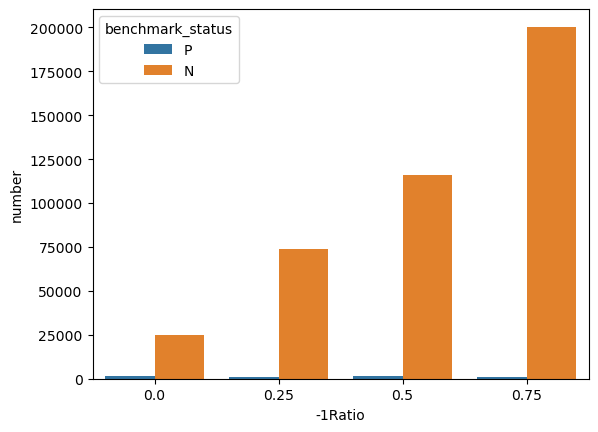

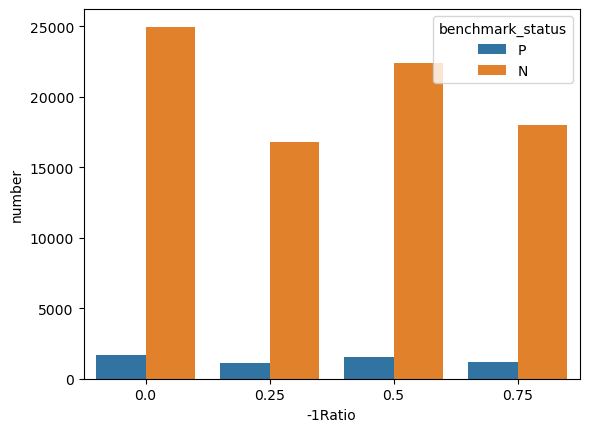

CPU times: user 29.4 s, sys: 408 ms, total: 29.8 s
Wall time: 29.4 s


In [89]:
%%time
fixedNegVSposRratio_keepCombination_allIdx,\
beforeFixRatio_test_Phaly_PPInum_frame,\
test_Phaly_PPInum_frame_fixedNegVSposRratio_keepCombination=getAllIdxOf_fixed_negVSpos_ratio_keepCombination_from_OriginalFrame(XBestHomologousDCAs_original=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs'],
                                                                        YBestHomologousDCAs_original=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'],
                                                                        fillMissingValue=-1,
                                                                         ifplot=True)

                                                                        


In [90]:
beforeFixRatio_test_Phaly_PPInum_frame

,-1Ratio,number,benchmark_status
0,0.00,1681,P
1,0.00,24958,N
2,0.25,1131,P
3,0.25,73810,N
4,0.50,1507,P
5,0.50,115711,N
6,0.75,1213,P
7,0.75,200401,N


In [91]:
i=0
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]+beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]/beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
i=2
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]+beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]/beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
i=4
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]+beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]/beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
i=6
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]+beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])
print(beforeFixRatio_test_Phaly_PPInum_frame.loc[i,"number"]/beforeFixRatio_test_Phaly_PPInum_frame.loc[i+1,"number"])

26639
0.06735315329753987
74941
0.01532312694756808
117218
0.013023826602483773
201614
0.006052864007664633


In [92]:
len(fixedNegVSposRratio_keepCombination_allIdx)

87663

In [93]:
%%time 
STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.iloc[fixedNegVSposRratio_keepCombination_allIdx,:],
                                                                inputFea_matrixList=[STRING115EggNog1224Spe511145_topDCAs_predicted_results['XtopDCAs'][fixedNegVSposRratio_keepCombination_allIdx,:],],
                                                                Y_matrix=STRING115EggNog1224Spe511145_topDCAs_predicted_results['YtopDCAs'][fixedNegVSposRratio_keepCombination_allIdx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                             )

# CPU times: user 5min 15s, sys: 15.7 s, total: 5min 31s
# Wall time: 18min 54s

after filtering,  (87663, 20) (87663,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 87663
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (70130, 20) (17533, 20) (70130,) (17533,)
[['COG0834', 'COG1763'], ['COG0024', 'COG0014'], ['COG2001', 'COG0180']]
len(cogs_train_dict): 62881
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 17533 3361 14172
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (73491, 20) (73491,) 4615.0 (14172,) 917.0
train LR model now : 
train RF model now : 
CPU times: user 1min 57s, sys: 12.9 s, total: 2min 10s
Wall time: 4min 1s


In [94]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]["Model"].best_estimator_

RandomForestClassifier(class_weight={1: 10}, max_depth=8, max_features=5,
                       n_estimators=500, n_jobs=4, random_state=0)

In [95]:
print(sum(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination['YtopFeas']))
STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination['YtopFeas'].shape

5532.0


(87663,)

In [96]:
sum(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["YtopFeas"]==1),sum(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["YtopFeas"]==0)

(5532, 82131)

In [97]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination.keys()

dict_keys(['XtopFeas', 'YtopFeas', 'XtopFeas_train', 'XtopFeas_test', 'ytopFeas_train', 'ytopFeas_test', 'LR', 'RF', 'updated_allPPI_allInfo_frame'])

In [98]:
STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination['updated_allPPI_allInfo_frame'].to_csv(Query_Benchmark_folder+"fixedNegVSposRratio_metadata.csv",
                                                                                                                                  header=True, index=None,sep="\t",
                                                                                                                                 )

In [99]:
%%time 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.iloc[fixedNegVSposRratio_keepCombination_allIdx,:],
                                                                inputFea_matrixList=[STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx,:],],
                                                                Y_matrix=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx], 
                                                                ML_methods=["LR","RF"],#["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                             )


# old RF parameters CPU times: user 2min 49s, sys: 30.5 s, total: 3min 20s
# Wall time: 7min 50s

# new RF parameters CPU times: user 4min 13s, sys: 30.7 s, total: 4min 43s
# Wall time: 22min 7s

after filtering,  (87663, 20) (87663,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 87663
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (70130, 20) (17533, 20) (70130,) (17533,)
[['COG0834', 'COG1763'], ['COG0024', 'COG0014'], ['COG2001', 'COG0180']]
len(cogs_train_dict): 62881
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 17533 3361 14172
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (73491, 20) (73491,) 4615.0 (14172,) 917.0
train LR model now : 
train RF model now : 
CPU times: user 1min 13s, sys: 14.2 s, total: 1min 27s
Wall time: 2min 42s


In [100]:
# testModel=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]["Model"]
# print(testModel.best_params_)

testModel=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]["Model"]
print(testModel.best_params_)

{'class_weight': {1: 10}, 'max_depth': 8, 'max_features': 2, 'n_estimators': 500}


In [101]:
%%time 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,\
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_testPPs=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.iloc[fixedNegVSposRratio_keepCombination_allIdx,:],
                                                                inputFea_matrixList=[STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx,:],],
                                                                Y_matrix=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                getTrainandTestPPTuples=True
                                                                
                                                                                             )

print(len(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))
print(len(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_testPPs))


count=0
for pp in STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs:
    if HighDCA_Query_allPPI_allInfo_dict[pp][0]=="P":
        count +=1
print(count)

after filtering,  (87663, 20) (87663,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 87663
type(cogs_train),type(cogs_test): <class 'list'> <class 'list'>
[['COG0834', 'COG1763'], ['COG0024', 'COG0014'], ['COG2001', 'COG0180']]
len(cogs_train_dict): 62881
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 17533 3361 14172
len(all_PPTuples_train),len(all_PPTuples_test): 73491 14172
73491
14172
4615
CPU times: user 9.59 s, sys: 1.68 s, total: 11.3 s
Wall time: 11.3 s


### check overfitting 



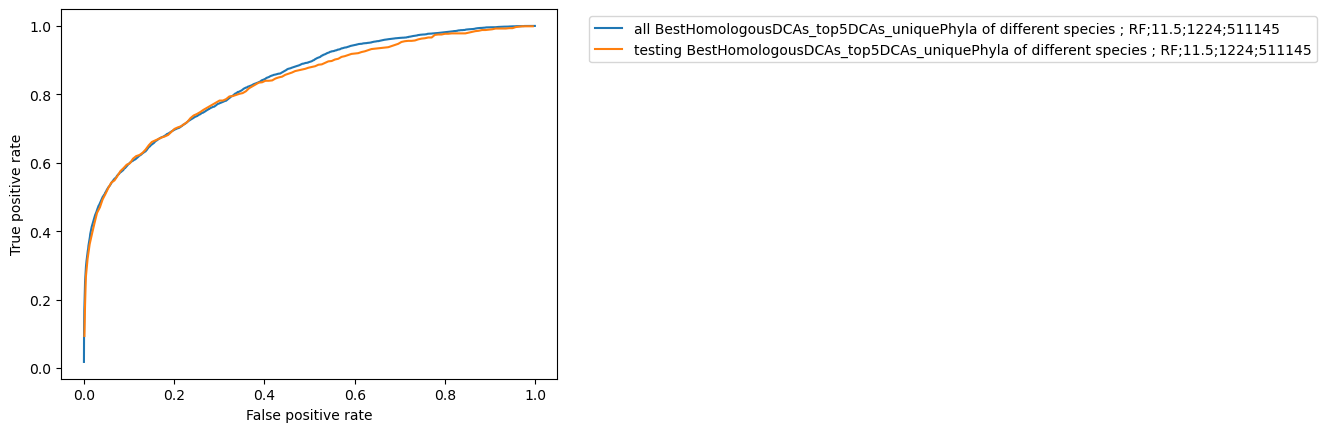

In [102]:

count_label="rate"
step=100
zoom_thres=None


# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["updated_allPPI_allInfo_frame"]["LR_onesProb"], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['YtopFeas'],
#              count_label=count_label,legend="all BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="testing BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["updated_allPPI_allInfo_frame"]["RF_onesProb"], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['YtopFeas'],
             count_label=count_label,legend="all BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="testing BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

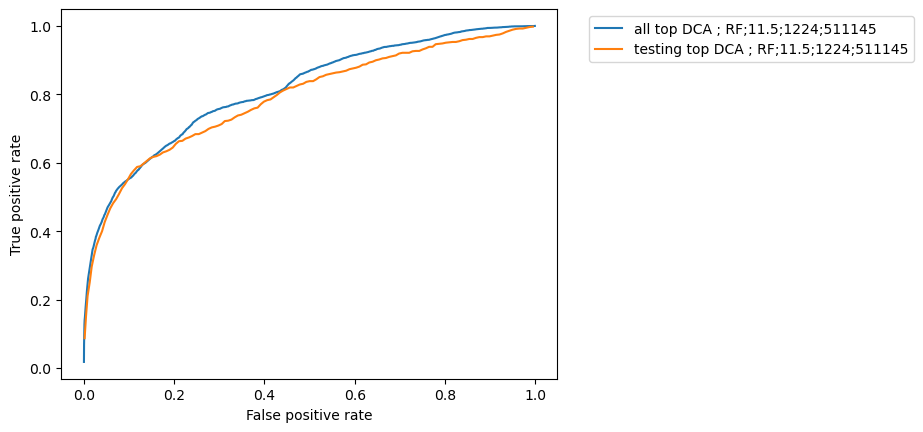

In [103]:

count_label="rate"
step=100
zoom_thres=None



DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["updated_allPPI_allInfo_frame"]["RF_onesProb"], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination['YtopFeas'],
             count_label=count_label,legend="all top DCA ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="testing top DCA ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

### save ML model to identify novel ppi in whole proteome level 

In [104]:
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['Model'].best_estimator_,f)
    
    
    
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['Model'].best_estimator_,f)
    
    
with open(os.path.join(Query_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs.pickle"),"wb") as f:
    pickle.dump(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,f)
    
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['updated_allPPI_allInfo_frame'].to_csv(\
os.path.join(Query_Benchmark_folder,
    f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame.csv"),
header=True,index=None)

# then transfer this to s3it 
# 
# rsync -az --progress /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination*  tfang@cluster.s3it.uzh.ch:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark

In [105]:
Query_Benchmark_folder


'/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/'

In [106]:

tobeSaved_frame=pd.DataFrame(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['XtopFeas'])

tobeSaved_frame.to_csv(Query_Benchmark_folder+"fixedNegVSposRratio_BestHomologousDCAs_top5DCAs.csv",
                                           header=True, index=None,sep="\t",  
                                                 )

### check replacing 

In [107]:
%%time 
replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.iloc[fixedNegVSposRratio_keepCombination_allIdx,:],
                                                                inputFea_matrixList=[replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx,:],],
                                                                Y_matrix=replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs'][fixedNegVSposRratio_keepCombination_allIdx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                    
                                                                                             )



after filtering,  (87663, 20) (87663,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 87663
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (70130, 20) (17533, 20) (70130,) (17533,)
[['COG0834', 'COG1763'], ['COG0024', 'COG0014'], ['COG2001', 'COG0180']]
len(cogs_train_dict): 62881
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 17533 3361 14172
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (73491, 20) (73491,) 4615.0 (14172,) 917.0
train LR model now : 
train RF model now : 
CPU times: user 17.3 s, sys: 14.8 s, total: 32.2 s
Wall time: 44.2 s


In [108]:
set(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['updated_allPPI_allInfo_frame']["LR_onesProb"])

{0.7627308892996225,
 0.7639416168087356,
 0.7684127833069713,
 0.7696032754372034,
 0.7715625224017663,
 0.7727416116892464,
 0.7770947325047578,
 0.7782534736741358}

In [109]:
set(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination['updated_allPPI_allInfo_frame']["RF_onesProb"])

{0.7581994747345384,
 0.7613199911958917,
 0.7639600829950927,
 0.7642704744612934,
 0.7695326133537146,
 0.7729287504297375,
 0.7756187738859316,
 0.7767843885935144}

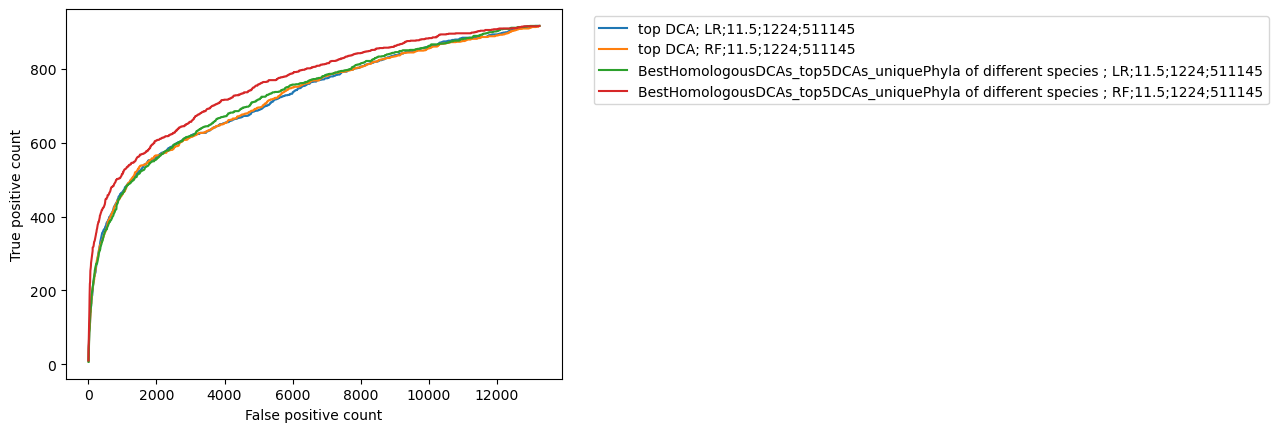

In [110]:

count_label="count"
step=10
zoom_thres=None


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top DCA; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

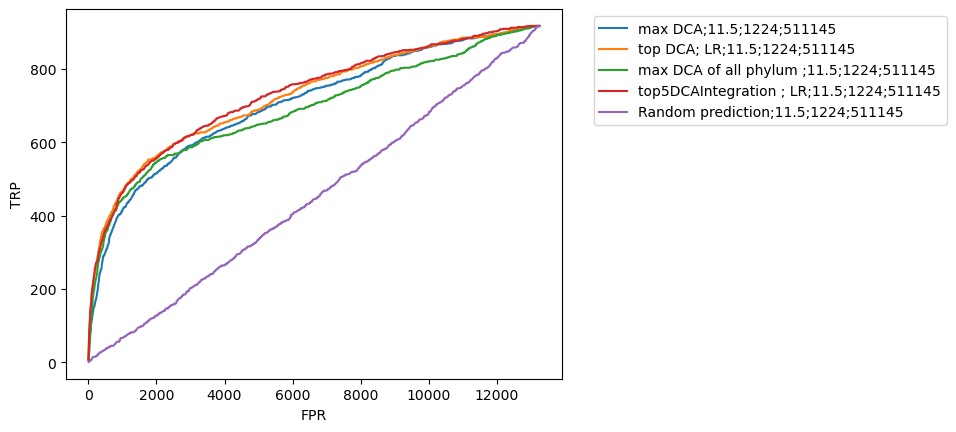

In [111]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="max DCA"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


# DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
#              replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="replacingDCAScores top5DCAIntegration ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)




# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="BestHomologousDCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"].max(axis=1), 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="max DCA of all phylum "+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top5DCAIntegration ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Random prediction"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

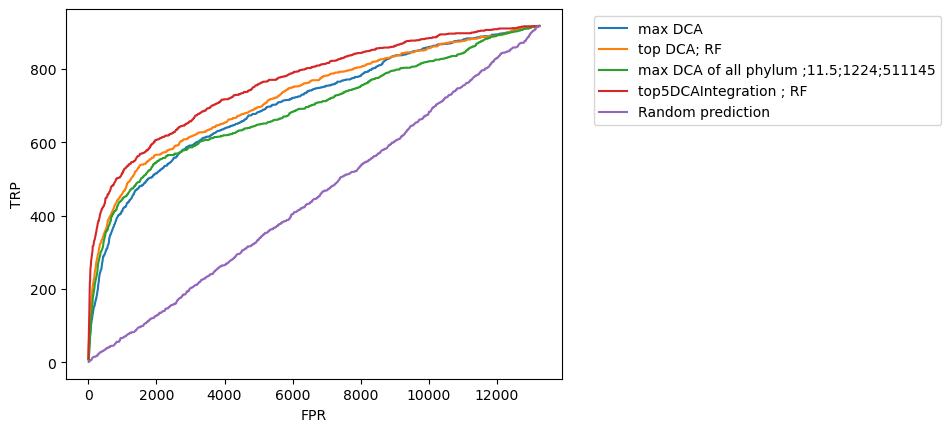

In [112]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="max DCA",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top DCA; RF",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"].max(axis=1), 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="max DCA of all phylum "+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="top5DCAIntegration ; RF",step=step,zoom_thres=zoom_thres)


Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Random prediction",step=step,zoom_thres=zoom_thres)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

In [113]:

# count_label="count"
# step=10
# zoom_thres=None




# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="top5DCAIntegration ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="top5DCAIntegration ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





# #plt.legend(loc='best')
# #plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()

In [114]:

# count_label="rate"
# step=10
# zoom_thres=None




# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["LR"]['LR_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="top5DCAIntegration ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="top5DCAIntegration ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





# #plt.legend(loc='best')
# #plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# plt.show()

# testing remove samples with many missing values 

In [115]:
%%time
notManyNans_0_idx,notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results=sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions(EggNOG_maxLevel="1224",currentSpe_TaxID="511145",STRING_Version="11.5",
                  Query_BestHomologousDCAs_dict=HighDCA_Query_BestHomologousDCAs_top5DCAs_dict,
                  ML_methods=[],#["LR","RF"],
                   EggNOG_group_level2=EggNOG_group_level2,
                  CoEvo_type="DCA",
                  deleting_column=None,
                  DCA_thres=0,
                    fillMissingValue=-1,
                    removeSamples_withManyNans=True,
                    allowedMissing_num=[0,],
                    topDCA_num=5,
                    given_benchmark_folder=Query_Benchmark_folder,
                    splitPosandNeg=False,
                    sort_frame=False,
                    CoEvo_data_folder=CoEvo_data_folder,
                    prefix="allPPI_",
                    benchmark_suffix="STRINGFullPhyBalancePhyla_Benchmark/",
                    n_jobs=n_jobs,
                    scoring_metrics=scoring_metrics,  
                    BestHomologousDCAs_dict_withStatus=True)

print(len(notManyNans_0_idx),sum(notManyNans_0_idx))

input_root_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/
 ML_inputs: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_STRINGFullPhyBalancePhyla_Benchmark/ML_inputs/
Benchmark_folder: /mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/
allPPI_allInfo_frame.shape: (420412, 5)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 420412
OnlyTopPosNeg_NonPara_XBestHomologousDCAs.shape: (420412, 20)
i_allowedMissing_num:, 0
after removeSamples_withManyNans, Onl

In [116]:
print(sum(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs']==1),
     sum(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['YBestHomologousDCAs']==0))

1681 24958


In [117]:
print(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs"].shape)
max(np.sum(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs"]==-1,axis=1))

(26639, 20)


0

In [118]:
%%time 
notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.loc[notManyNans_0_idx,:],
                                                                #inputFea_labelList=["DCAs",],
                                                                inputFea_matrixList=[STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs"][notManyNans_0_idx,:],],
                                                                Y_matrix=STRING115EggNog1224Spe511145_topDCAs_predicted_results["YtopDCAs"][notManyNans_0_idx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                             )

# CPU times: user 1min 4s, sys: 19.4 s, total: 1min 23s
# Wall time: 6min 52s

after filtering,  (26639, 20) (26639,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 26639
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (21311, 20) (5328, 20) (21311,) (5328,)
[['COG0217', 'COG0192'], ['COG0244', 'COG0222'], ['COG1159', 'COG0240']]
len(cogs_train_dict): 18421
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 5328 1341 3987
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (22652, 20) (22652,) 1384.0 (3987,) 297.0
train LR model now : 
LR ConvergenceWarning:  Liblinear failed to converge, increase the number of iterations.
train RF model now : 
CPU times: user 45 s, sys: 12.7 s, total: 57.6 s
Wall time: 2min 37s


In [119]:
%%time 
notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.loc[notManyNans_0_idx,:],
                                                                #inputFea_labelList=["DCAs",],
                                                                inputFea_matrixList=[STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs"][notManyNans_0_idx,:],],
                                                                Y_matrix=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["YBestHomologousDCAs"][notManyNans_0_idx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                             )

after filtering,  (26639, 20) (26639,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 26639
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (21311, 20) (5328, 20) (21311,) (5328,)
[['COG0217', 'COG0192'], ['COG0244', 'COG0222'], ['COG1159', 'COG0240']]
len(cogs_train_dict): 18421
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 5328 1341 3987
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (22652, 20) (22652,) 1384.0 (3987,) 297.0
train LR model now : 
train RF model now : 
CPU times: user 48.5 s, sys: 13.4 s, total: 1min 1s
Wall time: 56.5 s


In [120]:
print(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XtopFeas"].shape)
max(np.sum(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XtopFeas"]==-1,axis=1))

(26639, 20)


0

In [121]:

%%time 
notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results=sepCogPairs_ML_predictions_allTypeFeas(currentSpe_TaxID=Query_tuple[1],
                                                                EggNOG_group_level2=EggNOG_group_level2,
                                                                allPPI_allInfo_frame=HighDCA_Query_allPPI_allInfo_frame.loc[notManyNans_0_idx,:],
                                                                #inputFea_labelList=["DCAs",],
                                                                inputFea_matrixList=[replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs"][notManyNans_0_idx,:],],
                                                                Y_matrix=replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["YBestHomologousDCAs"][notManyNans_0_idx], 
                                                                ML_methods=["LR","RF"],
                                                                n_jobs=n_jobs,
                                                                scoring_metrics=scoring_metrics,
                                                                                             )

after filtering,  (26639, 20) (26639,)
len(CurrentSpe_EggNOG_group_level2_pro2cog): 4036
len(allPPI_cogs): 26639
OnlyTopPosNeg_NonPara_XtopDCAs.ndim: 2
XtopDCAs_train.shape,XtopDCAs_test.shape,ytopDCAs_train.shape,ytopDCAs_test.shape: (21311, 20) (5328, 20) (21311,) (5328,)
[['COG0217', 'COG0192'], ['COG0244', 'COG0222'], ['COG1159', 'COG0240']]
len(cogs_train_dict): 18421
len(cogs_test),len(Moved_test_idx),len(Kepted_test_idx): 5328 1341 3987
XtopFeas_train.shape,ytopFeas_train.shape,sum(ytopFeas_train),ytopFeas_test.shape,sum(ytopFeas_test): (22652, 20) (22652,) 1384.0 (3987,) 297.0
train LR model now : 
train RF model now : 
CPU times: user 13.1 s, sys: 13.9 s, total: 27 s
Wall time: 16.4 s


In [122]:
max(np.sum(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XtopFeas'],axis=1))
min(np.sum(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['XtopFeas'],axis=1))

20.0

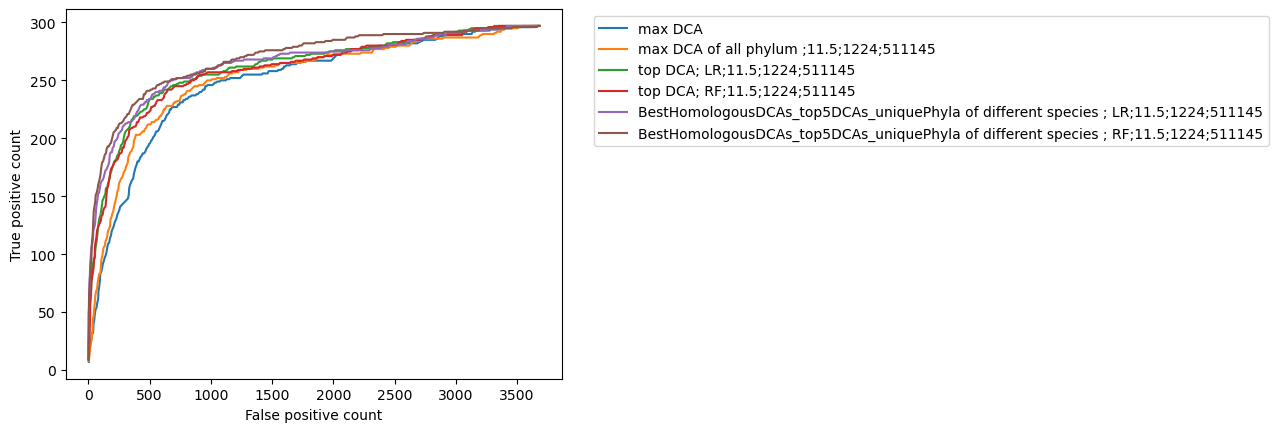

In [123]:

count_label="count"
step=10
zoom_thres=None



DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XtopFeas_test"].max(axis=1), 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA of all phylum "+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)




DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)





#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

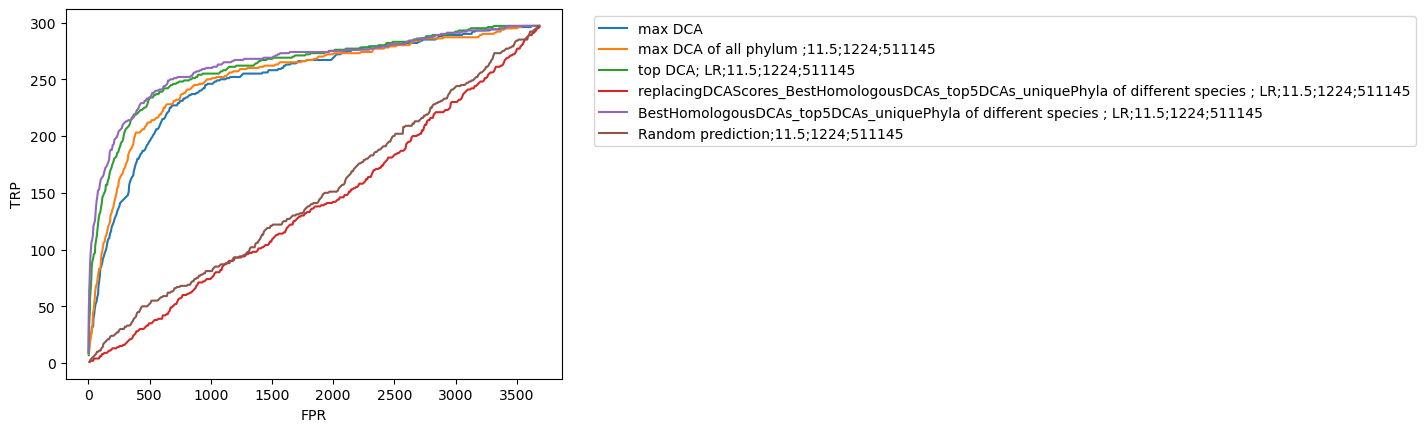

In [124]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XtopFeas_test"].max(axis=1), 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA of all phylum "+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)



DCA_RocCurve(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="replacingDCAScores_BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


# DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results["LR"]['LR_yBestHomologousDCAs_predict_prob'], 
#              notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_predicted_results["yBestHomologousDCAs_test"],
#              count_label=count_label,legend="BestHomologousDCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; LR"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction"+";11.5;1224;511145",step=step)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

In [125]:
notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'],

(array([[0.23519978, 0.76480022],
        [0.23519978, 0.76480022],
        [0.23519978, 0.76480022],
        ...,
        [0.23519978, 0.76480022],
        [0.23519978, 0.76480022],
        [0.23519978, 0.76480022]]),)

In [126]:
set(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['updated_allPPI_allInfo_frame']["LR_onesProb"])

{0.7648002218775353}

In [127]:
set(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results['updated_allPPI_allInfo_frame']["RF_onesProb"])

{0.7640714655160951}

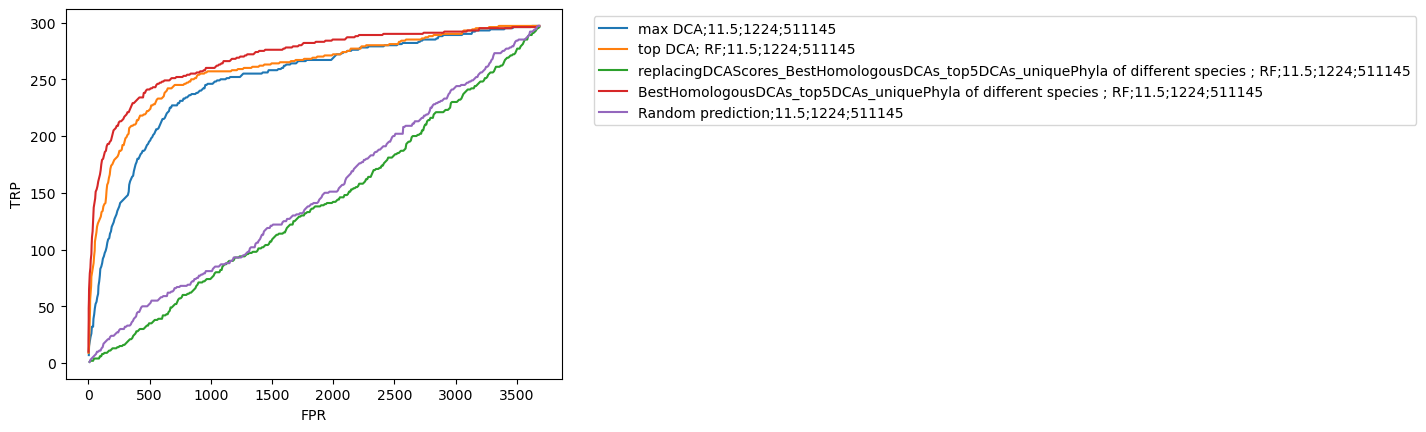

In [128]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)

DCA_RocCurve(notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="replacingDCAScores_BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="BestHomologousDCAs_top5DCAs_uniquePhyla of different species ; RF"+";11.5;1224;511145",step=step,zoom_thres=zoom_thres)


Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction"+";11.5;1224;511145",step=step)




#plt.legend(loc='best')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

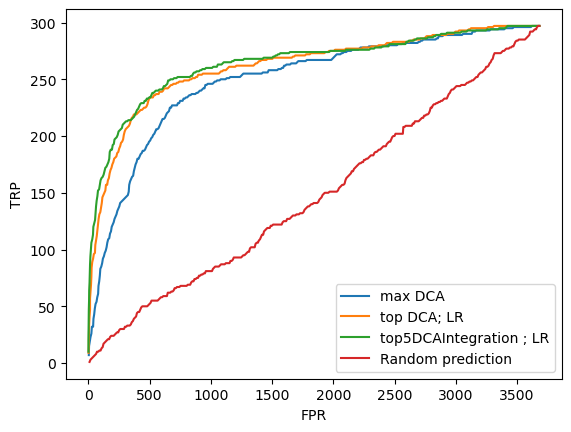

In [129]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; LR",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["LR"]['LR_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top5DCAIntegration ; LR",step=step,zoom_thres=zoom_thres)


Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction",step=step)




#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

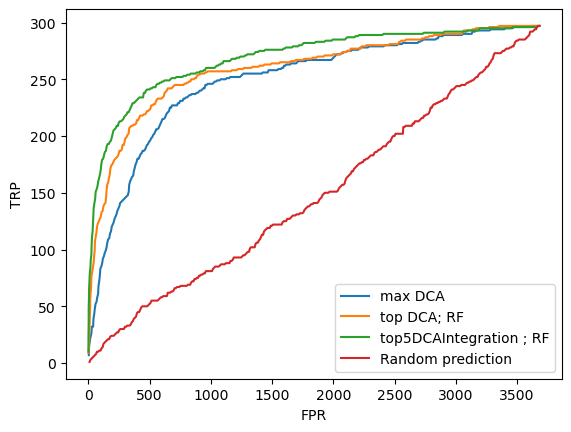

In [130]:

count_label="count"
step=10
zoom_thres=None




DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="max DCA",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top DCA; RF",step=step,zoom_thres=zoom_thres)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="top5DCAIntegration ; RF",step=step,zoom_thres=zoom_thres)


Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction",step=step)




#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()

# figure 4A , performance of phylum integratin and RF model 

In [131]:
fig3C_list=list()
for _ ,row in beforeFixRatio_test_Phaly_PPInum_frame.iterrows():
    #print(row[1])
    fig3C_list.append([row[0]*4,row[1],"unfixedRatio_"+row[2]])
    
for _ ,row in test_Phaly_PPInum_frame_fixedNegVSposRratio_keepCombination.iterrows():
    #print(row[1])
    fig3C_list.append([row[0]*4,row[1],"fixedRatio_"+row[2]])
    
fig3C_frame=pd.DataFrame(fig3C_list,
                        columns=["Num Of missing values","Count", "Benchmark status"])



In [132]:
24958/1681

14.84711481261154

In [133]:
test_model=STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]["Model"]
test_model.best_estimator_.feature_importances_

array([0.06841292, 0.09044698, 0.100194  , 0.09229159, 0.10072163,
       0.02577218, 0.03452373, 0.05155252, 0.04381787, 0.05440133,
       0.0239864 , 0.03668725, 0.03676744, 0.05176319, 0.05228414,
       0.01802529, 0.02143521, 0.02652495, 0.03568076, 0.03471062])

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.7 µs


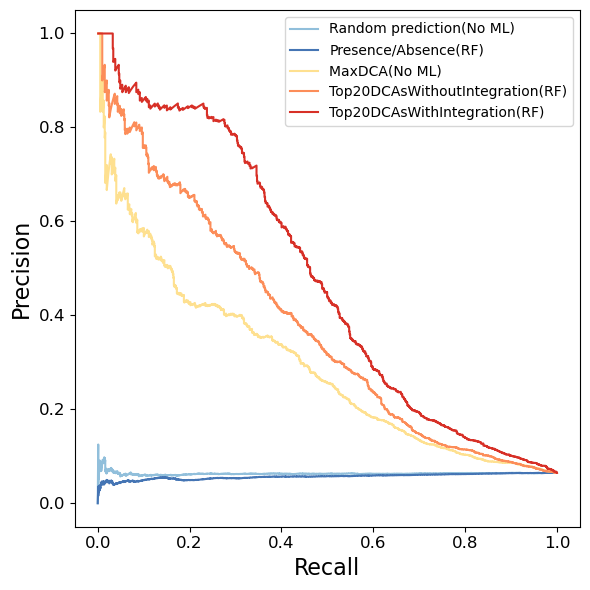

In [134]:
%time
plotType="PR"
count_label="rate"

colors=[ '#91bfdb', '#4575b4','#fee090', '#fc8d59', '#d73027']
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig3 = plt.figure(figsize=(6,6))
step=1#10#1
zoom_thres=None





axB =plt.subplot(1,1,1)
DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
             color=colors[0],
            randomplot=True)

DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Presence/Absence(RF)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
             color=colors[1],
            )

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[2],)





DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[3],)

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegration(RF)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[4],)





#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axB.text(-300, 1000, 'B', weight='bold')
# axB.legend(fontsize=8)

axB.legend().set_visible(False)
axB.set_xlabel("Recall",fontsize=16)
axB.set_ylabel("Precision",fontsize=16)
# axB.set_title("PR curve ",loc='center',fontsize=16)
axB.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig3.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_RFmodel.pdf", dpi=600)




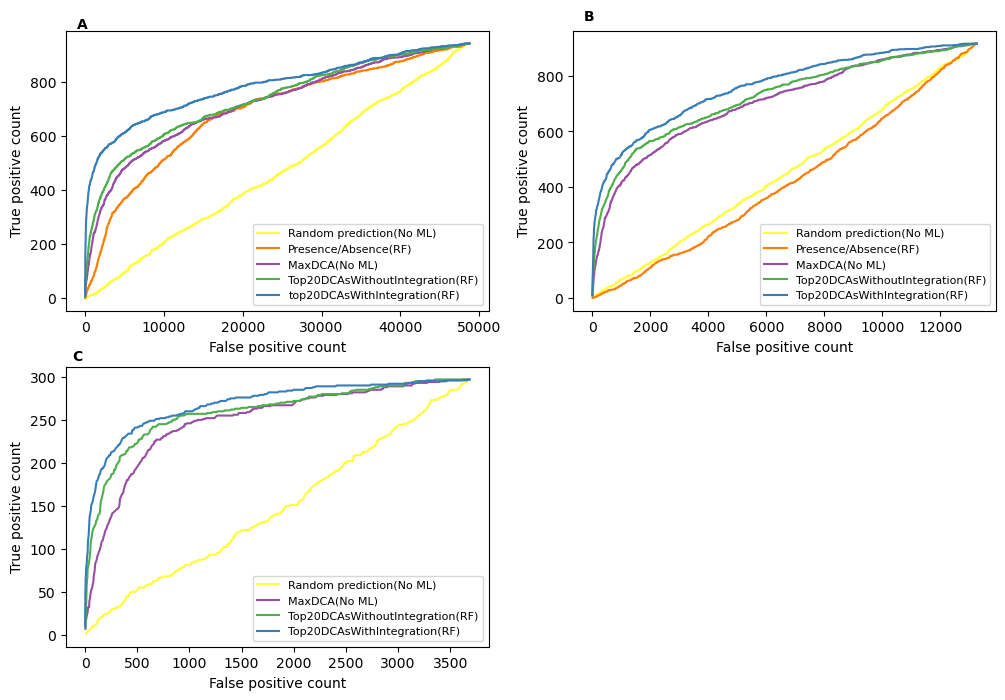

CPU times: user 2.79 s, sys: 397 ms, total: 3.18 s
Wall time: 2.71 s


In [135]:
%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig3 = plt.figure(figsize=(12,8))
count_label="count"
step=10 #10
zoom_thres=None

colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(2,2,1)
Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
                legend="Random prediction(No ML)",
                step=step,
                color=colors[0]
               )

DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="Presence/Absence(RF)",
             step=step,zoom_thres=zoom_thres,
                color=colors[1])

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="MaxDCA(No ML)",
             step=step,zoom_thres=zoom_thres,color=colors[2])


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="Top20DCAsWithoutIntegration(RF)",
             step=step,zoom_thres=zoom_thres,color=colors[3])

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="top20DCAsWithIntegration(RF)",
             step=step,zoom_thres=zoom_thres,color=colors[4])



#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
axA.text(-1000, 1000, 'A', weight='bold')
axA.legend(fontsize=8)



axB =plt.subplot(2,2,2)
Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,zoom_thres=zoom_thres,color=colors[0])

DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Presence/Absence(RF)",step=step,zoom_thres=zoom_thres,color=colors[1])


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,color=colors[2])

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[3])

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[4])



#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
axB.text(-300, 1000, 'B', weight='bold')
axB.legend(fontsize=8)




axC =plt.subplot(2,2,3)
Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,color=colors[0])

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,color=colors[2])

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[3])


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[4])



axC.text(-120, 318.75, 'C', weight='bold') 
axC.legend(fontsize=8)
plt.show()

fig3.savefig("/mnt/mnemo5/tao/temp_figures/Fig3.pdf", dpi=600)




##   dropped,figure 3 sup , check if add max DCA of all phyla ,

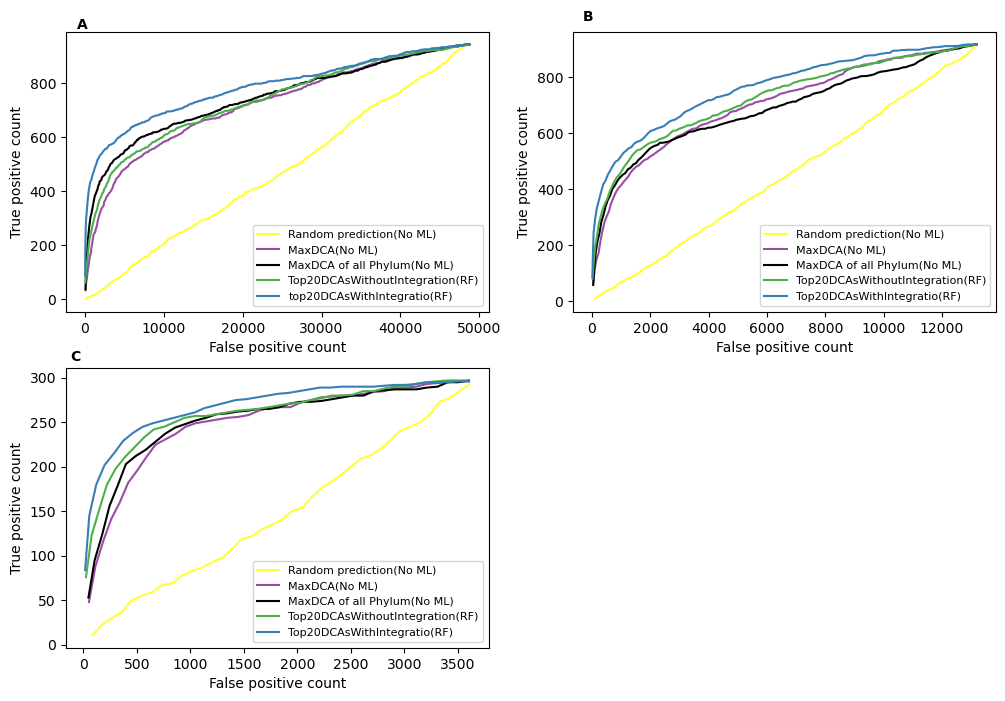

In [136]:
#%%time 
# Fig 3 
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig3 = plt.figure(figsize=(12,8))
count_label="count"
step=100 #10
zoom_thres=None

colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(2,2,1)
Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
                legend="Random prediction(No ML)",
                step=step,
                color=colors[0]
               )

# DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
#              replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
#              count_label=count_label,
#              legend="Presence/Absence(RF)",
#              step=step,zoom_thres=zoom_thres,
#                 color=colors[1])


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="MaxDCA(No ML)",
             step=step,zoom_thres=zoom_thres,color=colors[2])


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs_test"].max(axis=1), 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="MaxDCA of all Phylum(No ML)",
             step=step,zoom_thres=zoom_thres,color="black")


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="Top20DCAsWithoutIntegration(RF)",
             step=step,zoom_thres=zoom_thres,color=colors[3])

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="top20DCAsWithIntegratio(RF)",
             step=step,zoom_thres=zoom_thres,color=colors[4])



#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
axA.text(-1000, 1000, 'A', weight='bold')
axA.legend(fontsize=8)



axB =plt.subplot(2,2,2)
Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,zoom_thres=zoom_thres,color=colors[0])

# DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
#              replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
#              count_label=count_label,legend="Presence/Absence(RF)",step=step,zoom_thres=zoom_thres,color=colors[1])


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,color=colors[2])



DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["XtopFeas_test"].max(axis=1), 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,
             legend="MaxDCA of all Phylum(No ML)",
             step=step,zoom_thres=zoom_thres,color="black")

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[3])

DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["RF"]['RF_ytopFeas_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegratio(RF)",step=step,zoom_thres=zoom_thres,color=colors[4])



#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
axB.text(-300, 1000, 'B', weight='bold')
axB.legend(fontsize=8)




axC =plt.subplot(2,2,3)
Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,color=colors[0])

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,color=colors[2])


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XtopFeas_test"].max(axis=1), 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,
             legend="MaxDCA of all Phylum(No ML)",
             step=step,zoom_thres=zoom_thres,color="black")

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,color=colors[3])


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegratio(RF)",step=step,zoom_thres=zoom_thres,color=colors[4])



axC.text(-120, 318.75, 'C', weight='bold') 
axC.legend(fontsize=8)
plt.show()

fig3.savefig("/mnt/mnemo5/tao/temp_figures/Fig3.pdf", dpi=600)




In [137]:
# %%time 
# # Fig 3 
# # https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# # https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# # https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# # https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

# fig3 = plt.figure(figsize=(12,8)) #plt.figure(figsize=(12,8))
# count_label="count"
# step=100 #10
# zoom_thres=None

# colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

# axA = plt.subplot(2,2,1)
# Random_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
#              count_label=count_label,
#                 legend="Random prediction(No ML)",
#                 step=step,
#                 color=colors[0]
#                )


# DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
#              STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
#              count_label=count_label,
#              legend="MaxDCA(No ML)",
#              step=step,zoom_thres=zoom_thres,color=colors[2])

# DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["XBestHomologousDCAs_test"].max(axis=1), 
#              STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
#              count_label=count_label,
#              legend="MaxDCA of all Phylum(No ML)",
#              step=step,zoom_thres=zoom_thres,color=colors[3])


# #plt.legend(loc='best')
# #plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# #axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
# #ax1.set_xlabel("taaata",loc='left top')
# #axA.text(-1000, 1000, 'A', weight='bold')

# axA.legend(fontsize=8)

# plt.show()

## sup figure 1 

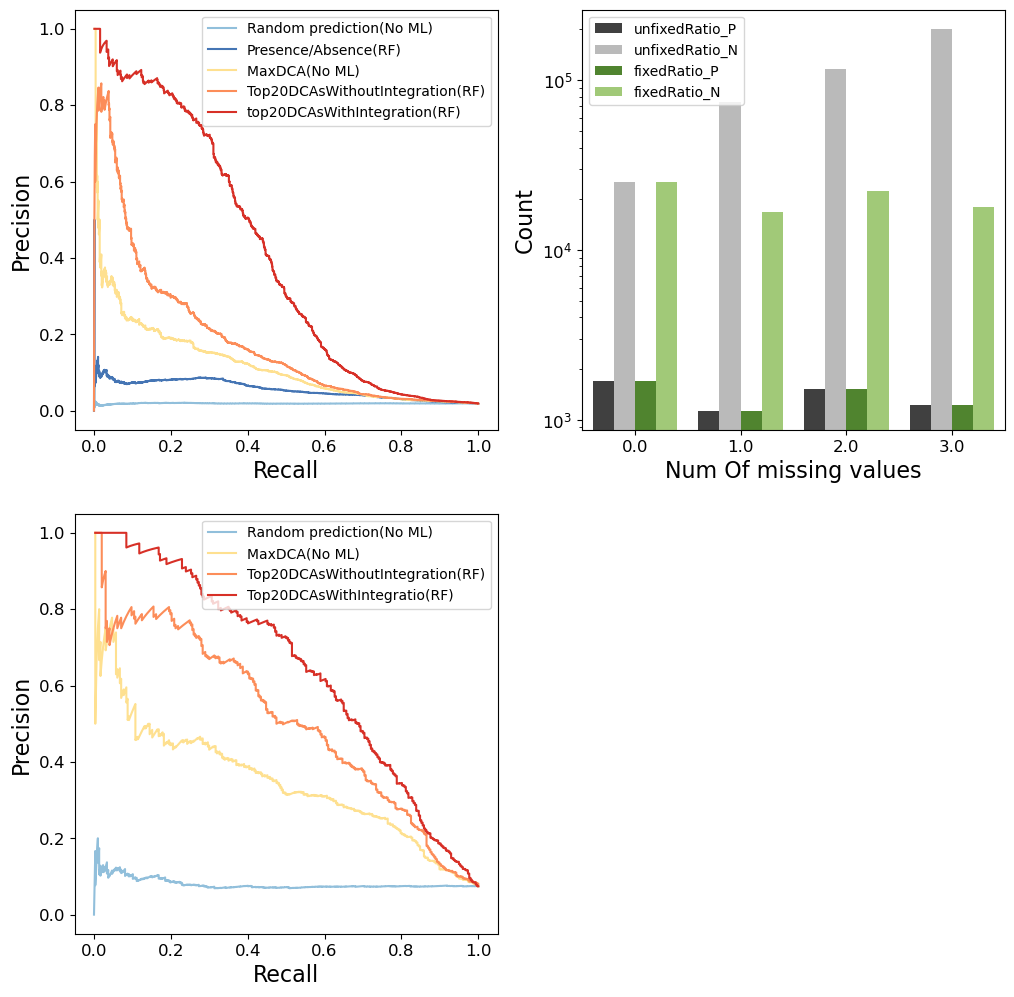

In [138]:
fig3 = plt.figure(figsize=(12,12)) #(15,8)

plotType="PR"
count_label="rate"

step=1#10#1
zoom_thres=None

colors=[ '#91bfdb', '#4575b4','#fee090', '#fc8d59', '#d73027']

axA = plt.subplot(2,2,1)

DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="Random prediction(No ML)",
             step=step,zoom_thres=zoom_thres,
            plotType=plotType, 
             color=colors[0],
             randomplot=True)


DCA_RocCurve(replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             replacingDCAScores_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="Presence/Absence(RF)",
             step=step,zoom_thres=zoom_thres,
            plotType=plotType,
             color=colors[1],
            )


DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopDCAs_test"][:,0], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="MaxDCA(No ML)",
             step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[2],)




DCA_RocCurve(STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopDCAs_test"],
             count_label=count_label,
             legend="Top20DCAsWithoutIntegration(RF)",
             step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[3],)


DCA_RocCurve(STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_yBestHomologousDCAs_predict_prob'], 
             STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["yBestHomologousDCAs_test"],
             count_label=count_label,
             legend="top20DCAsWithIntegration(RF)",
             step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[4],)




axA.legend().set_visible(False)
axA.set_xlabel("Recall",fontsize=16)
axA.set_ylabel("Precision",fontsize=16)
# axA.set_title("PR curve ",loc='center',fontsize=16)
axA.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)

axC= plt.subplot(2,2,2)
# https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146
# Create an array with the colors you want to use
# colors = ["#404040", "#bababa","#ca0020","#f4a582"] # https://colorbrewer2.org/#type=diverging&scheme=RdGy&n=4
colors = ["#404040", "#bababa","#4d9221","#a1d76a",]
# Set your custom color palette
#sns.set_palette(sns.color_palette(colors))
customPalette = sns.set_palette(sns.color_palette(colors))
ax=sns.barplot(x="Num Of missing values", y="Count",hue="Benchmark status", 
            data=fig3C_frame,
           palette=customPalette,
              ax=axC)
ax.set_yscale("log")
# axC.legend(fontsize=8)
sns.reset_defaults()

axC.legend().set_visible(False)
axC.set_xlabel("Num Of missing values",fontsize=16)
axC.set_ylabel("Count",fontsize=16)
# axC.set_title("PR curve ",loc='center',fontsize=16)
axC.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)




axD =plt.subplot(2,2,3)
plotType="PR"
count_label="rate"
colors=[ '#91bfdb', '#4575b4','#fee090', '#fc8d59', '#d73027']



DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Random prediction(No ML)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
             color=colors[0],
            randomplot=True)

DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["XtopFeas_test"][:,0], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="MaxDCA(No ML)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
             color=colors[2],
            )



# Random_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
#              count_label=count_label,legend="Random prediction(No ML)",step=step,
#                plotType=plotType)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_topDCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithoutIntegration(RF)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[3],)


DCA_RocCurve(notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["RF"]['RF_ytopFeas_predict_prob'], 
             notManyNans_0_STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results["ytopFeas_test"],
             count_label=count_label,legend="Top20DCAsWithIntegratio(RF)",step=step,zoom_thres=zoom_thres,
            plotType=plotType,
            color=colors[4],)


axD.legend().set_visible(False)
axD.set_xlabel("Recall",fontsize=16)
axD.set_ylabel("Precision",fontsize=16)
# axD.set_title("PR curve ",loc='center',fontsize=16)
axD.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.show()

fig3.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_SupFigure.pdf", dpi=600)

